In [1]:
import os, sys
if 'google.colab' in sys.modules:
    %cd /content
    if not os.path.isdir('PyMPDATA'):
        !git clone --depth 1 https://github.com/atmos-cloud-sim-uj/PyMPDATA.git
    %cd PyMPDATA
    !pip install -r requirements.txt

In [2]:
import os, sys
if 'google.colab' in sys.modules:
    %cd /content/PyMPDATA/PyMPDATA_examples/advection_diffusion_1d
sys.path.insert(0, os.path.join(os.getcwd(), '../..'))

In [17]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

from PyMPDATA import Factories
from PyMPDATA.options import Options
from PyMPDATA.arakawa_c.boundary_condition.periodic_boundary_condition import PeriodicBoundaryCondition

from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
%matplotlib inline
#%matplotlib widget

In [4]:
#Eq parameters
mu = 0.05

solution_symbolic = sp.sympify("sin(pi*(x-c*t))*exp(-mu*pi**2*t) + 2", rational=True)
u0_symbolic = solution_symbolic.subs({"t":0})#sp.sympify("sin(pi * x) + 2", rational=True)

#Sim Parameters
steps_per_iter = 1
opts = Options(n_iters=3, non_zero_mu_coeff=True, infinite_gauge=True, flux_corrected_transport=True)

#Plot Parameters
r_array = np.arange(1, 7, 2)
c_array = np.linspace(0.05, 0.7, 7)

In [5]:
results = {}
domains = {}
solutions = {}
max_error = {}

for r in r_array:
    print(f"R {r}")
    nx = 16 * 2**r

    domain_symbolic = [-1+sp.Rational(2*i, nx) for i in range(nx)]
    domain = np.array(domain_symbolic, dtype=np.float)
    u0 = np.array([u0_symbolic.subs("x", x) for x in domain_symbolic], dtype=np.float)

    solver = Factories.advection_diffusion_1d(
        options=opts,
        advectee=u0,
        advector=0,
        boundary_conditions=(PeriodicBoundaryCondition(),)
    )

    for C in c_array:
        print("\t", C)

        #Params
        dx = 2 / nx
        phys_c = 2 * C / nx
        phys_mu = mu * dx**2
        nt = int(4 / C / dx)

        solution = solution_symbolic.subs({"c" : phys_c, "mu" : phys_mu})
        #display(solution)

        ###SIM
        solver.advector.data[0][:] = C
        solver.advectee.get()[:] = u0

        numerical_results = [solver.advectee.get().copy()]
        for i in range(nt):
            solver.advance(steps_per_iter, mu_coeff=(mu,))
            numerical_results.append(solver.advectee.get().copy())

        numerical_results = np.array(numerical_results)
        key = (r, C)
        results[key] = numerical_results
        domains[key] = domain
        solutions[key] = solution
        
        ###ERR
        u = sp.lambdify("x,t", solution)
        steps = np.arange(nt + 1, dtype=np.int).reshape(-1, 1) * steps_per_iter
        error = np.sqrt(np.sum((u(domain, steps) - numerical_results)**2, axis=1)/nx)
        max_idx = np.argmax(error)
        max_error[key] = error[max_idx]


R 1
	 0.05
	 0.15833333333333333
	 0.26666666666666666
	 0.37499999999999994
	 0.4833333333333333
	 0.5916666666666667
	 0.7
R 3
	 0.05
	 0.15833333333333333
	 0.26666666666666666
	 0.37499999999999994
	 0.4833333333333333
	 0.5916666666666667
	 0.7
R 5
	 0.05
	 0.15833333333333333
	 0.26666666666666666
	 0.37499999999999994
	 0.4833333333333333
	 0.5916666666666667
	 0.7


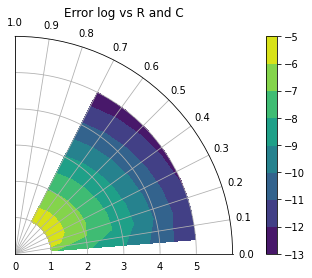

In [6]:
theta_array = c_array * np.pi/2

X, Y = np.meshgrid(theta_array, r_array)
Z = np.array(list(max_error.values())).reshape(len(r_array), len(theta_array))
Z = np.log2(Z)
Z[Z>0] = 0

ax = plt.subplot(111, projection='polar')

cnt = ax.contourf(X, Y, Z)
legend = plt.colorbar(cnt, ax=ax, pad=0.1)


ax.set_rlim(0, max(r_array)+1)
ax.set_thetalim(0, np.pi/2)
ax.set_rticks(range(0, max(r_array)+1))
ax.set_rlabel_position(-22.5)
theta_ticks = np.linspace(0, 90, 11)
ax.set_thetagrids(theta_ticks, theta_ticks/90)
ax.grid(True)

ax.set_title("Error log vs R and C", va='bottom')
plt.show()

<ipython-input-14-f2c97e77d1b6>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


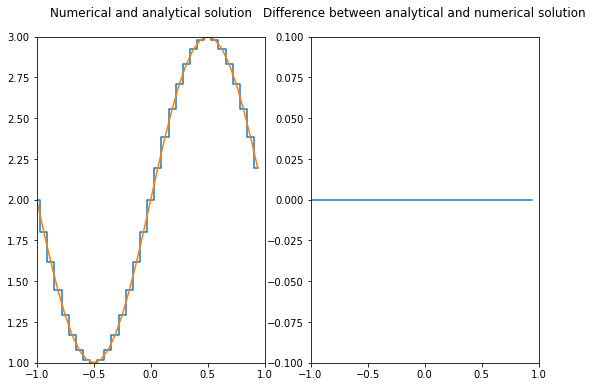

In [14]:
key = (1,.05)
numerical_result = results[key]
domain = domains[key]
u = sp.lambdify("x,t", solutions[key])


fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(121)
ax.set_title("Numerical and analytical solution", pad = 20)
#ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(-1, 1)
ax.set_ylim(1, 3)
line, = ax.step(domain, numerical_result[0], where='mid')
line2, = ax.plot(domain, u(domain, 0))
ax = fig.add_subplot(122)
ax.set_title("Difference between analytical and numerical solution", pad = 20)
line3, = ax.plot(domain, u(domain, 0) - numerical_result[0])
ax.set_ylim(-.1, .1)
ax.set_xlim( -1, 1)

interval = 25 #ms
frame_list = np.arange(len(numerical_result), dtype=np.int)

def update(frame_num):
    line.set_ydata(numerical_result[frame_num])
    line2.set_ydata(u(domain, frame_num * steps_per_iter))
    line3.set_ydata(u(domain, frame_num * steps_per_iter) - numerical_result[frame_num])
    return line, line2, line3

animation = FuncAnimation(fig, update, frames=frame_list, interval=interval, blit=True)
fig.show()

In [18]:
if 'TRAVIS' not in os.environ:
    display(HTML(animation.to_html5_video()))